In [ ]:
import torch
import deep.model as models
import deep.training as training
from tool.preprocessing import DataCollection
from tool.create_dataset import creation

In [13]:
#Hyperparameters
NUM_RECORD = 5
TOTAL_DIMENSION = NUM_RECORD*6
PROB = 0.75
BATCH_SIZE=128
NUM_HIDDEN = 512
LR=0.00001
NUM_EPOCHS = 100

#Data Loader
collection = DataCollection(drop_null=True)
dataset,gt = collection.get_dataset(drop_datetime=False) # in dataset is already present the gt value

In [ ]:

division = creation(dataset,NUM_RECORD,p=PROB)

mlp_dataset_X_train= division[0][0].flatten(-2)
mlp_dataset_y_train= division[0][1].flatten(-2)[:,0]
mlp_dataset_X_test = division[1][0].flatten(-2)
mlp_dataset_y_test = division[1][1].flatten(-2)[:,0]

In [ ]:
import torch.nn as nn
def eval(mlp: nn.Module, data_loader: torch.utils.data.DataLoader, 
             device: torch.device):
  
  loss_fun = nn.MSELoss().to(device)
  correct = 0
  total = 0
  
  with torch.no_grad():
    for x, y in data_loader:
     
      x, y = x.to(device), y.to(device)
      y_pred = mlp(x)
      #print(y_pred.shape,y.shape)
      mean = loss_fun(y_pred,y)
      #print(mean)
      correct+=mean
      
      total+=1
  return correct/total

In [ ]:
import torch
import numpy as np
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Training
model = models.AirMLP_6(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loader = data.DataLoader(data.TensorDataset(mlp_dataset_X_train, mlp_dataset_y_train), shuffle=True, batch_size=BATCH_SIZE)
loader_test = data.DataLoader(data.TensorDataset(mlp_dataset_X_test, mlp_dataset_y_test), shuffle=False, batch_size=BATCH_SIZE)


try:
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        for X_batch, y_batch in loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()

            y_pred = model(X_batch)
            #print(y_pred.shape)
            loss = loss_fn(y_pred, y_batch)
            #print(y_batch.shape, y_pred.shape)
            
            loss.backward()

            optimizer.step()
        
        
        
        # Validation
        if epoch % 2 != 0:
            continue
        model.eval()
        last_loss = (eval(model, loader, device),eval(model, loader_test, device))
        print(f"Epoch {epoch} train mse.: {eval(model, loader, device):.3f} test mse.: {eval(model, loader_test, device):.3f}")
except KeyboardInterrupt:
    model.eval()
    last_loss = (eval(model, loader, device),eval(model, loader_test, device))
    print(f"Epoch {epoch} train mse.: {eval(model, loader, device):.3f} test mse.: {eval(model, loader_test, device):.3f}")
    NUM_EPOCHS = epoch
    

In [ ]:
torch.save(model,r'.\results\weights\weights_mlp_20230419-6-numhidd.pth')

In [14]:
import os
os.listdir(r'.\results\weights')
model_rest = models.AirMLP_6(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
model_rest = torch.load(r'.\results\weights\weights_mlp_20230419-6-numhidd.pth')
model_rest.eval()

AirMLP_6(
  (net): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Linear(in_features=30, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [15]:
model = model_rest

tensor(0, device='cuda:0')


NameError: name 'last_loss' is not defined

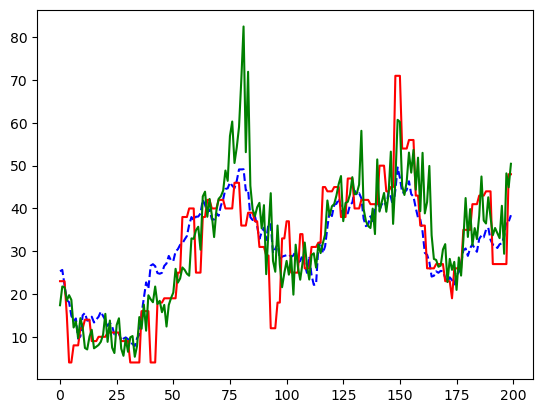

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

ari = collection.ari1953
ari = pd.merge(ari,gt,how="inner", on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})

x_test = creation(ari,NUM_RECORD)[0][0].flatten(-2)
y_test = creation(ari,NUM_RECORD)[0][1].flatten(-2)[:,0]
model.eval()
print(y_test.isnan().sum())
y_pred = model(x_test[:200,:])
#y_test=y_test.cpu().detach().numpy()[:200]
y_test=y_test[:200]


pred_plot = plt.plot(y_pred.cpu().detach().numpy(), '--b',label="Prediction")
test_plot = plt.plot(y_test.cpu().detach().numpy(),'-r',label="Ground Truth")
test_plot = plt.plot(ari["pm2p5"][:200].reset_index()["pm2p5"],'-g',label="Original")
test_plot = plt.title(f"MLP\n batch: {BATCH_SIZE}, num_hidden: {NUM_HIDDEN}, layer: 6, epochs: {NUM_EPOCHS}. adam\ntrain:{last_loss[0]:.3f}, test: {last_loss[1]:.3f}\nLR: {LR}, records:{NUM_RECORD}")
test_plot = plt.xlabel('days')
test_plot = plt.ylabel('PM2.5')
leg = plt.legend(loc='upper left')



plt.show()